In [1]:
import datetime as dt
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.geodesic
import dask
from IPython.display import clear_output
import matplotlib as mpl
import matplotlib.pyplot as plt
# Use for .mp4 video:
# plt.rcParams["animation.html"] = "html5"
# Use for javascript animation:
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
# Edit these based on where these are on your system.
statsdir = Path('/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats')
pixeldir = Path('/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/mcstracking')

In [3]:
# It's useful to make a dict so that you can access each file by datetime:
track_pixel_paths = sorted(pixeldir.glob("**/*.nc"))
date_path_map = {
    dt.datetime.strptime(p.stem, "mcstrack_%Y%m%d_%H%M"): p
    for p in track_pixel_paths
}

In [4]:
# Only 2019 fully uncompressed so far:
list(date_path_map.items())[0]

(datetime.datetime(2000, 6, 1, 0, 30),
 PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/mcstracking/20000601.0000_20010101.0000/2000/06/01/mcstrack_20000601_0030.nc'))

In [5]:
list(date_path_map.items())[-1]

(datetime.datetime(2020, 12, 31, 23, 30),
 PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/mcstracking/20200101.0000_20210101.0000/2020/12/31/mcstrack_20201231_2330.nc'))

In [6]:
# Smaller datasets - load completely.
dsframe = xr.open_dataset(track_pixel_paths[123])
dsframe

<xarray.Dataset>
Dimensions:                        (time: 1, lat: 1200, lon: 3600)
Coordinates:
  * time                           (time) datetime64[ns] 2000-06-06T03:30:00....
  * lat                            (lat) float32 -59.95 -59.85 ... 59.85 59.95
  * lon                            (lon) float32 -179.9 -179.9 ... 179.9 179.9
Data variables:
    base_time                      (time) datetime64[ns] 2000-06-06T03:30:00....
    longitude                      (lat, lon) float32 -179.9 -179.9 ... 179.9
    latitude                       (lat, lon) float32 -59.95 -59.95 ... 59.95
    tb                             (time, lat, lon) float32 272.0 ... 273.0
    precipitation                  (time, lat, lon) float32 0.0009731 ... 0.0
    cloudtype                      (time, lat, lon) float64 nan nan ... nan nan
    cloudnumber                    (time, lat, lon) float64 nan nan ... nan nan
    split_tracknumbers             (time, lat, lon) float64 nan nan ... nan nan
    merge_tracknumbers             (time, lat, lon) float64 nan nan ... nan nan
    cloudtracknumber_nomergesplit  (time, lat, lon) float64 nan nan ... nan nan
    cloudtracknumber               (time, lat, lon) float64 nan nan ... nan nan
    pcptracknumber                 (time, lat, lon) float64 nan nan ... nan nan
Attributes:
    Title:                     Robust MCS pixel-level tracking data
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Fri Mar 18 09:41:31 2022
    startdate:                 20000601.0000
    enddate:                   20010101.0000
    precipitation_datasource:  imerg
    mcs_tb_area_thresh:        40000
    mcs_tb_duration_thresh:    4
    mcs_pf_majoraxis_thresh:   100
    mcs_pf_durationthresh:     4

In [7]:
def global_plot(da, field, method='contourf', **kwargs):
    time = pd.Timestamp(round(dsframe.time.values.item() / 1e9) * 1e9)
    if 'cmap' not in kwargs and 'colors' not in kwargs:
        kwargs['cmap'] = 'jet'
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    fig.set_size_inches((19, 5))
    ax.set_title(time)
    ax.coastlines()
    im = getattr(ax, method)(dsframe.longitude, dsframe.latitude, dsframe[field].isel(time=0), **kwargs)
    plt.colorbar(im)
    return fig, ax

cmap = mpl.cm.get_cmap('jet')

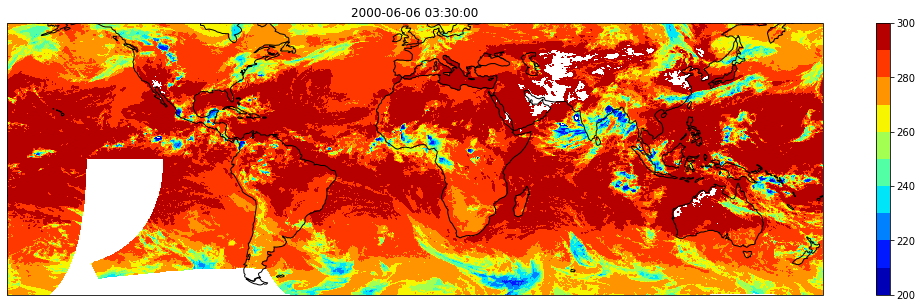

In [8]:
# Note the TB data are not complete. For 2019-03-06 03:30 - See the missing values stretching from Russia/Japan to south of Australia.
global_plot(dsframe, 'tb', levels=np.arange(200, 310, 10));

In [10]:
len(date_path_map)

179646

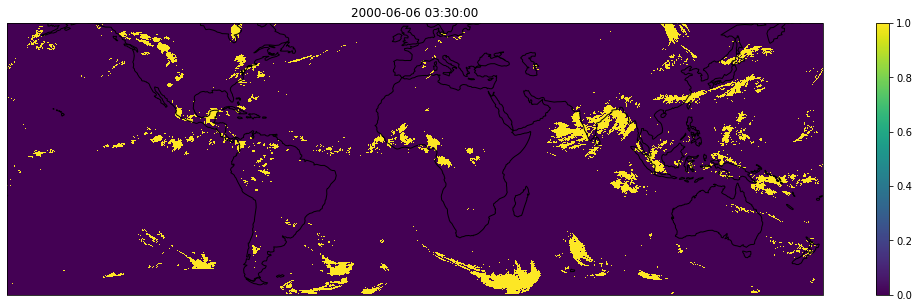

In [14]:
time = pd.Timestamp(round(dsframe.time.values.item() / 1e9) * 1e9)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches((19, 5))
ax.set_title(time)
ax.coastlines()
im = ax.pcolormesh(dsframe.longitude, dsframe.latitude, dsframe['tb'].isel(time=0) <= 241)
plt.colorbar(im)

In [32]:
pixel_paths_2020XX01 = [v for k, v in date_path_map.items() if k.year == 2020 and k.day == 1]

In [33]:
datb = xr.open_mfdataset(pixel_paths_2020XX01).tb.load()

In [34]:
datb_ccs_lat = (datb <= 241).mean(dim=['time', 'lon'])
datb_core_lat = (datb <= 225).mean(dim=['time', 'lon'])

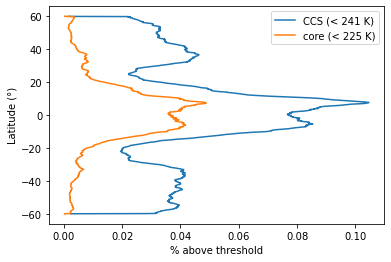

In [40]:
plt.plot(datb_ccs_lat * np.cos(datb_ccs_lat.lat * np.pi / 180), datb_ccs_lat.lat, label='CCS (< 241 K)')
plt.plot(datb_core_lat * np.cos(datb_core_lat.lat * np.pi / 180), datb_core_lat.lat, label='core (< 225 K)')
plt.ylabel('Latitude (°)')
plt.xlabel('% above threshold')
plt.legend()

In [36]:
datb_core_lat = (datb <= 225).mean(dim=['time', 'lon'])

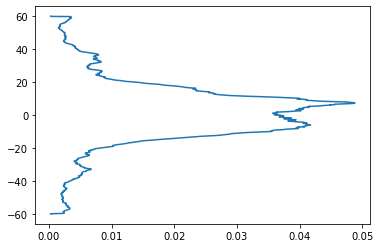